### Load the dataset

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
sns.set_palette('muted')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train.columns = [_.lower() for _ in train.columns]
test.columns = [_.lower() for _ in test.columns]
print('train.shape: {}'.format(train.shape))
print('test.shape: {}'.format(test.shape))

train.shape: (26729, 10)
test.shape: (11456, 8)


### Get a glance at the dataset

In [3]:
train.head()

,animalid,name,datetime,outcometype,outcomesubtype,animaltype,sexuponoutcome,ageuponoutcome,breed,color
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,Dog,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,Cat,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,Dog,Neutered Male,2 years,Pit Bull Mix,Blue/White
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,Cat,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,Dog,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan


In [4]:
test.head()

,id,name,datetime,animaltype,sexuponoutcome,ageuponoutcome,breed,color
0,1,Summer,2015-10-12 12:15:00,Dog,Intact Female,10 months,Labrador Retriever Mix,Red/White
1,2,Cheyenne,2014-07-26 17:59:00,Dog,Spayed Female,2 years,German Shepherd/Siberian Husky,Black/Tan
2,3,Gus,2016-01-13 12:20:00,Cat,Neutered Male,1 year,Domestic Shorthair Mix,Brown Tabby
3,4,Pongo,2013-12-28 18:12:00,Dog,Intact Male,4 months,Collie Smooth Mix,Tricolor
4,5,Skooter,2015-09-24 17:59:00,Dog,Neutered Male,2 years,Miniature Poodle Mix,White


### Check out the missing values

In [5]:
train.isnull().sum()

animalid              0
name               7691
datetime              0
outcometype           0
outcomesubtype    13612
animaltype            0
sexuponoutcome        1
ageuponoutcome       18
breed                 0
color                 0
dtype: int64

In [6]:
test.isnull().sum()

id                   0
name              3225
datetime             0
animaltype           0
sexuponoutcome       0
ageuponoutcome       6
breed                0
color                0
dtype: int64

There are too many missing values in outcomesubtype, and it dosen't exist in the test data, we may just drop it.

For the other missing values in name, sexuponoutcome, and ageuponoutcome, we consider either filling in them or turning them into some other attribute.

### Outcometype

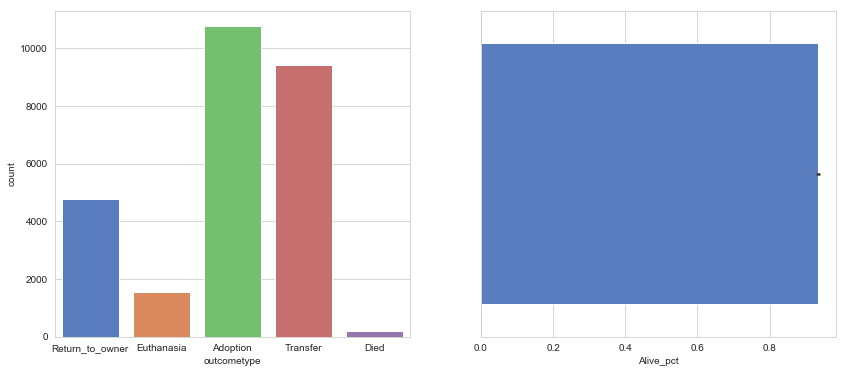

In [7]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=train, x='outcometype')
plt.subplot(1, 2, 2)
sns.barplot(train['outcometype'].apply(lambda x: 1 if x in ['Return_to_owner', 'Adoption', 'Transfer'] else 0))
plt.xlabel('Alive_pct')
plt.show()

Most of the animals left the shelter alive, only less than 15% died.

### Name

In [8]:
train['hasname'] = train.name.notnull().astype(int)

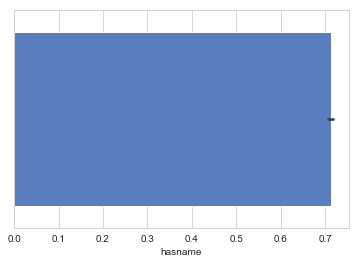

In [9]:
sns.barplot(data=train, x='hasname')

About 70% of the animals in the shelter got a name

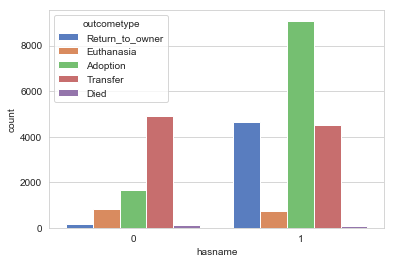

In [10]:
sns.countplot(data=train, x='hasname', hue='outcometype')

Animals with a name definitely had a higher possiblity to be returned to owner or to be adopted.

We will keep this 'hasname' attribute and drop the original 'name'

### datetime

In [11]:
train['datetime'] = pd.to_datetime(train.datetime)
train['year'] = train.datetime.dt.year
train['month'] = train.datetime.dt.month
train['day'] = train.datetime.dt.day
train['hour'] = train.datetime.dt.hour
train = train.drop('datetime', axis=1)

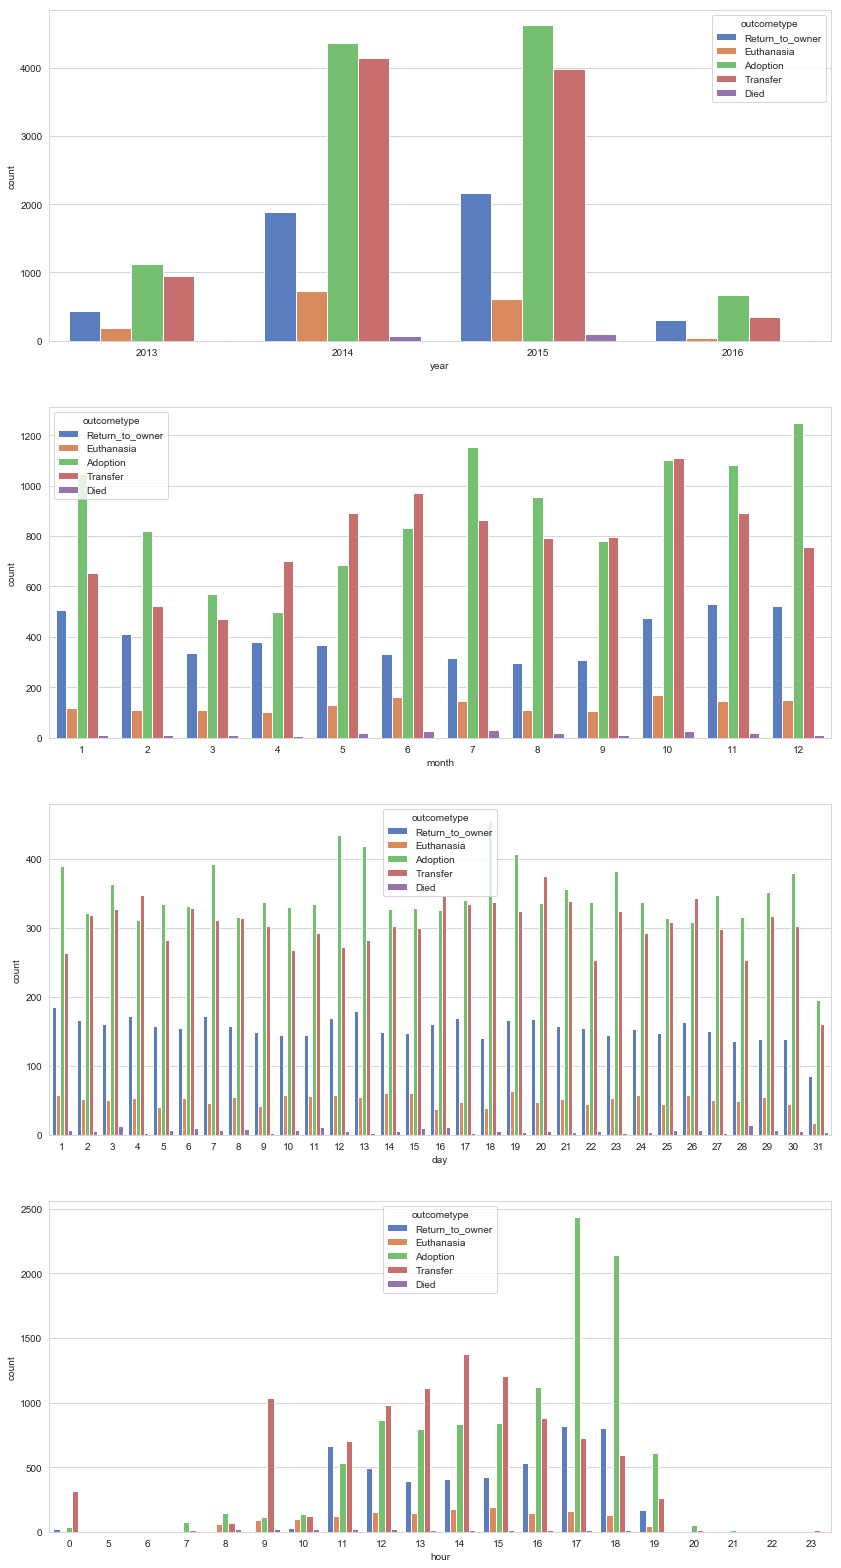

In [12]:
plt.figure(figsize=(14, 28))
for i, feat in enumerate(['year', 'month', 'day', 'hour']):
    plt.subplot(4, 1, i+1)
    sns.countplot(data=train, x=feat, hue='outcometype')

Year, month, day don't seem to have a influlence on the target, but hour certainly have.

We got much more count of 'return_to_owner' and 'adoption' around 17 and 18, which makes sense, people may pick up their pets after work.

### Sexuponoutcome

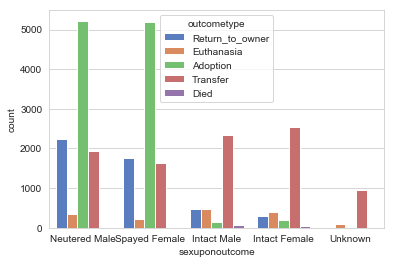

In [13]:
sns.countplot(data=train, x='sexuponoutcome', hue='outcometype')

People definitely prefer Neutered/Spayed animals.

In [14]:
train['sex_only'] = train.sexuponoutcome.fillna('Unknown').map({
    'Neutered Male': 'Male',
    'Spayed Female': 'Female',
    'Intact Male': 'Male',
    'Intact Female': 'Female',
    'Unknown': 'Unknown'
})

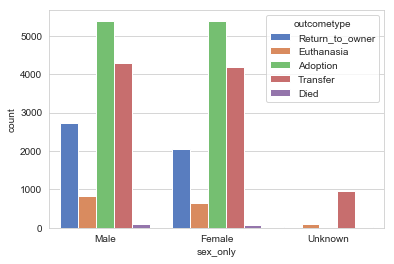

In [15]:
sns.countplot(data=train, x='sex_only', hue='outcometype')

Sex alone doesn't have any influence on the outcome.

In [16]:
train['taken'] = train.outcometype.apply(lambda x: x in ['Return_to_owner', 'Adoption']).astype(int)

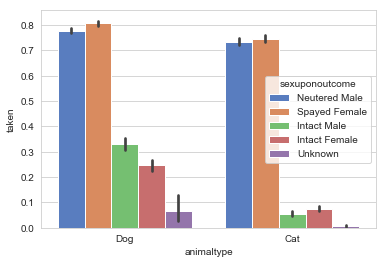

In [17]:
sns.barplot(data=train, x='animaltype', y='taken', hue='sexuponoutcome')

Peopler seems to be more tolarence of intact dogs then of cats.

We will create a attribute 'intact' to replace the original 'sexuponoutcome'

### animaltype

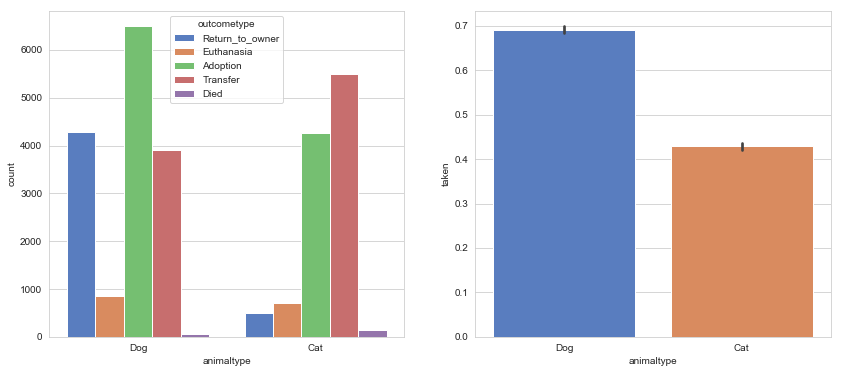

In [18]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.countplot(data=train, x='animaltype', hue='outcometype')
plt.subplot(1, 2, 2)
sns.barplot(data=train, x='animaltype', y='taken')

Dogs are more likely to be taken(i.e. returned to owner or adopted)

### ageuponoutcome

In [19]:
train.ageuponoutcome.isnull().sum()

18

In [20]:
train.ageuponoutcome.value_counts()

1 year       3969
2 years      3742
2 months     3397
3 years      1823
1 month      1281
3 months     1277
4 years      1071
5 years       992
4 months      888
6 years       670
3 weeks       659
5 months      652
6 months      588
8 years       536
7 years       531
2 weeks       529
10 months     457
10 years      446
8 months      402
4 weeks       334
9 years       288
7 months      288
12 years      234
9 months      224
1 weeks       171
11 months     166
1 week        146
13 years      143
11 years      126
3 days        109
2 days         99
14 years       97
15 years       85
1 day          66
4 days         50
6 days         50
16 years       36
5 days         24
0 years        22
17 years       17
5 weeks        11
18 years       10
19 years        3
20 years        2
Name: ageuponoutcome, dtype: int64

In [21]:
'20 years'.split(' ')[0]

'20'

In [22]:
# Transform the age into number of days

def age_transfer(age_str):
    num = age_str.split(' ')[0]
    num = int(num)
    if 'day' in age_str:
        return num
    elif 'week' in age_str:
        return num * 7
    elif 'month' in age_str:
        return num * 30
    elif 'year' in age_str:
        return num * 365
    else:
        return np.nan

In [23]:
train['ageuponoutcome'] = train.ageuponoutcome.fillna('0').apply(age_transfer)

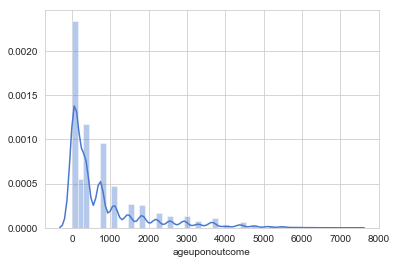

In [24]:
sns.distplot(train.ageuponoutcome.fillna(0))

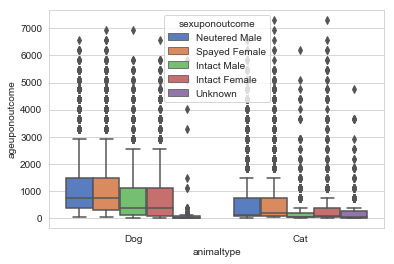

In [25]:
sns.boxplot(data=train, x='animaltype', y='ageuponoutcome', hue='sexuponoutcome')

There is a clear differenct in different animaltype&intact_or_not group, we will use this information to fill in the missing values in ageuponoutcome.

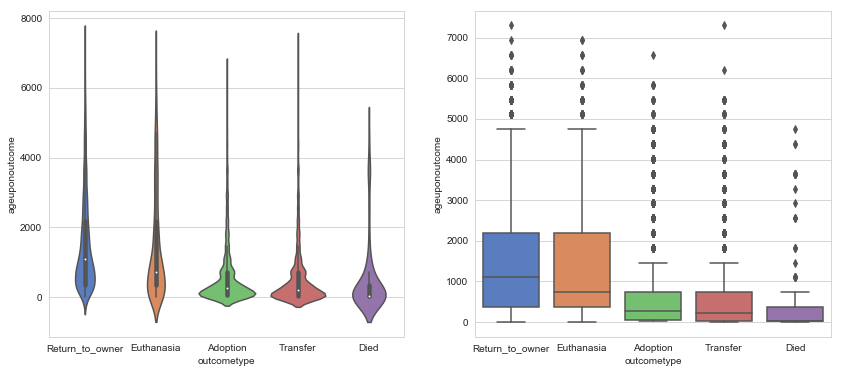

In [26]:
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.violinplot(data=train, x='outcometype', y='ageuponoutcome')
plt.subplot(1, 2, 2)
sns.boxplot(data=train, x='outcometype', y='ageuponoutcome')
plt.show()

There are clear age difference in different outcometype groups

### breed

In [27]:
train['mix'] = train.breed.str.contains('Mix').astype(int)

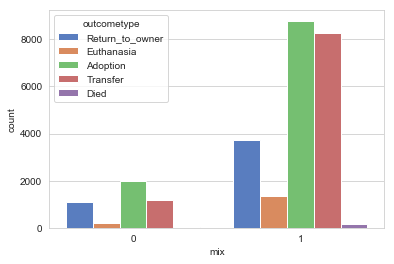

In [28]:
sns.countplot(data=train, x='mix', hue='outcometype')

In [29]:
train['domestic'] = train.breed.str.contains('Domestic').astype(int)

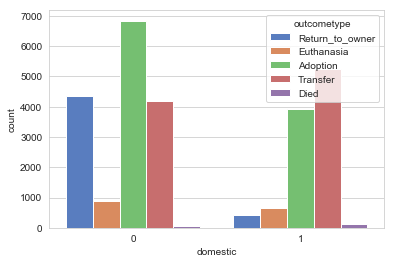

In [30]:
sns.countplot(data=train, x='domestic', hue='outcometype')

Non-domestic pets are more likely to be taken.

try create binary attributes for some popular breeds

In [31]:
popular_breeds = train.breed.str.extract(r'(\w+) ', expand=False).value_counts()[:20].index.values
for breed in popular_breeds:
    train[breed] = train.breed.str.contains(breed).astype(int)

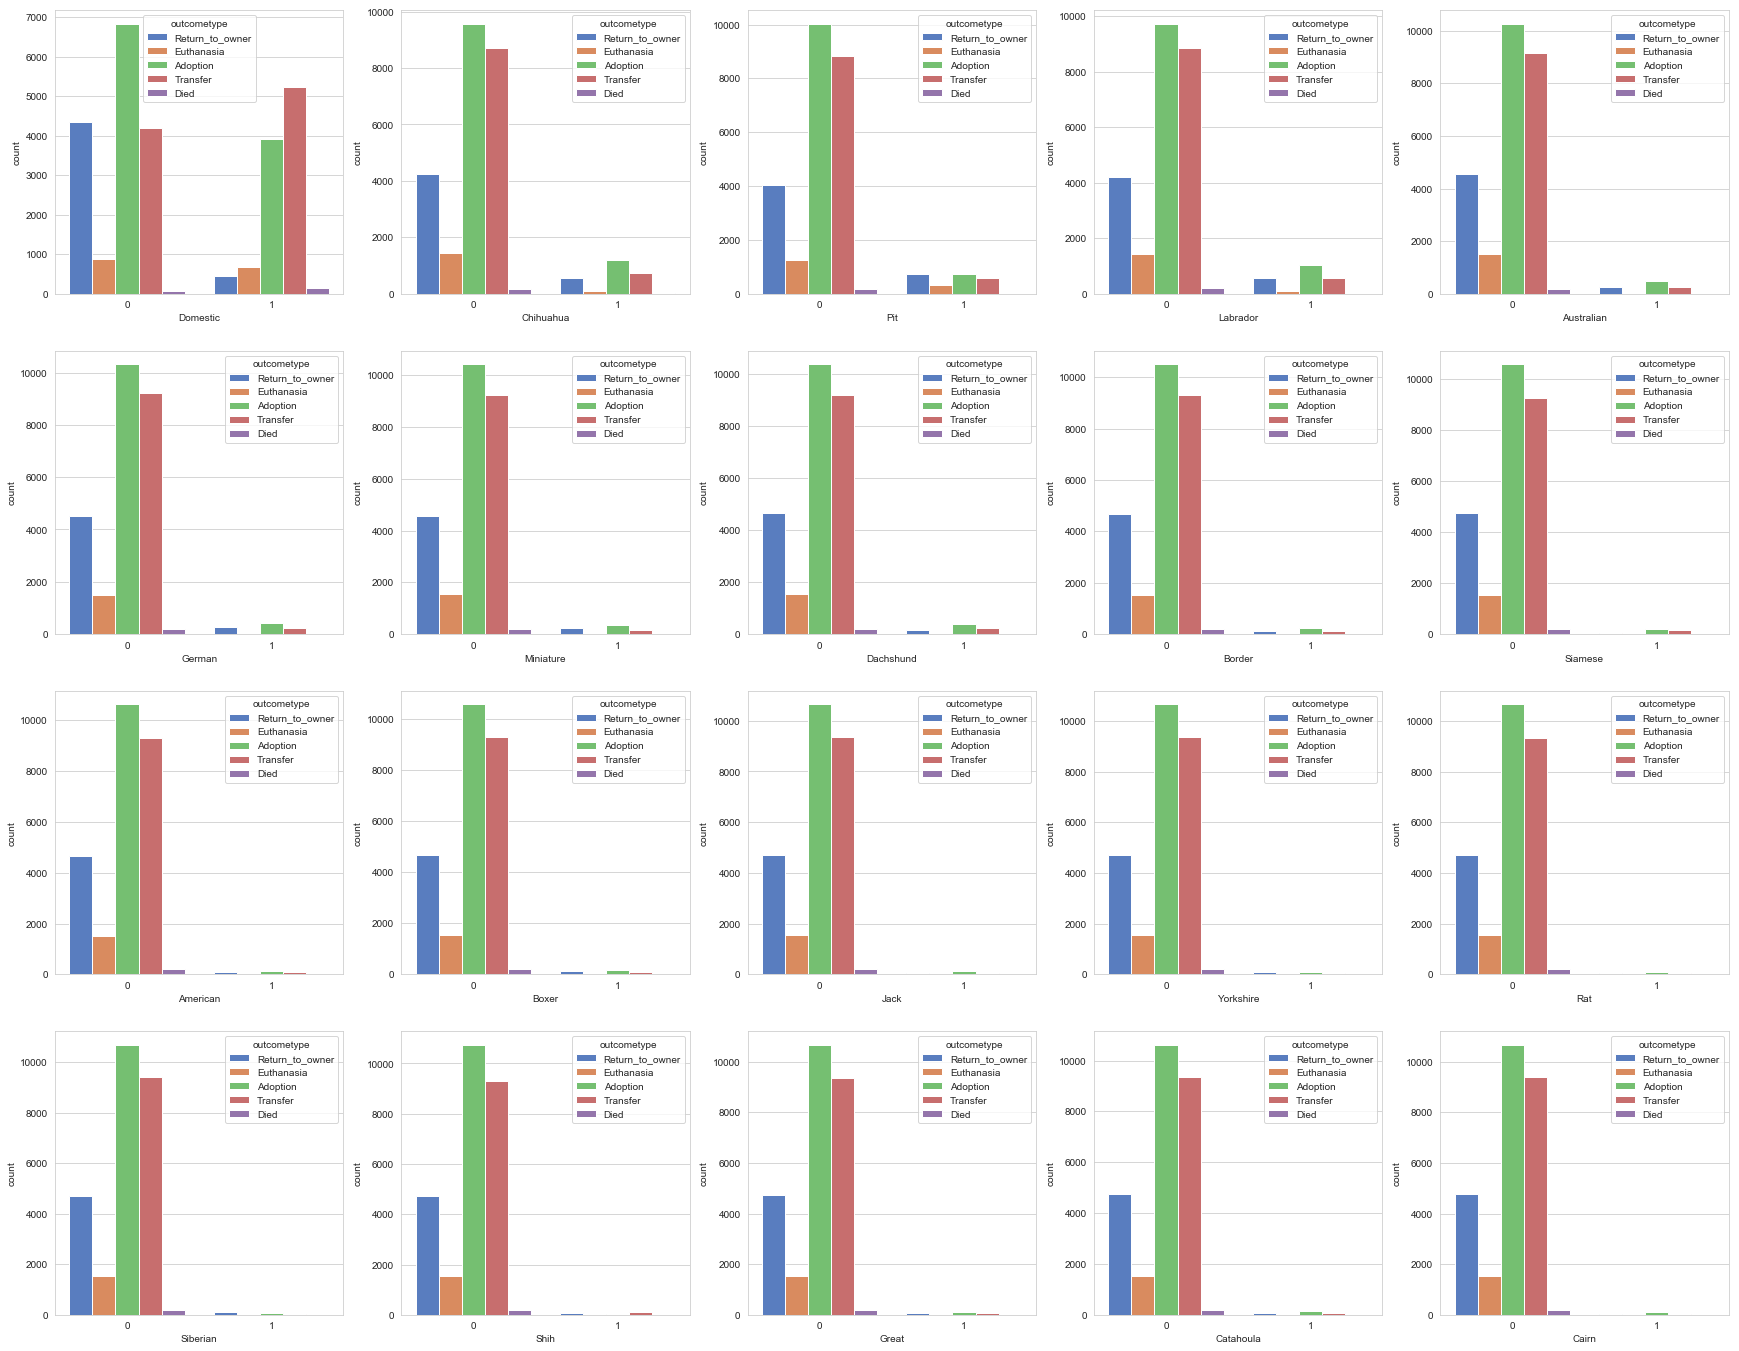

In [32]:
plt.figure(figsize=(30, 24))
for i, breed in enumerate(popular_breeds):
    plt.subplot(4, 5, i+1)
    sns.countplot(data=train, x=breed, hue='outcometype')

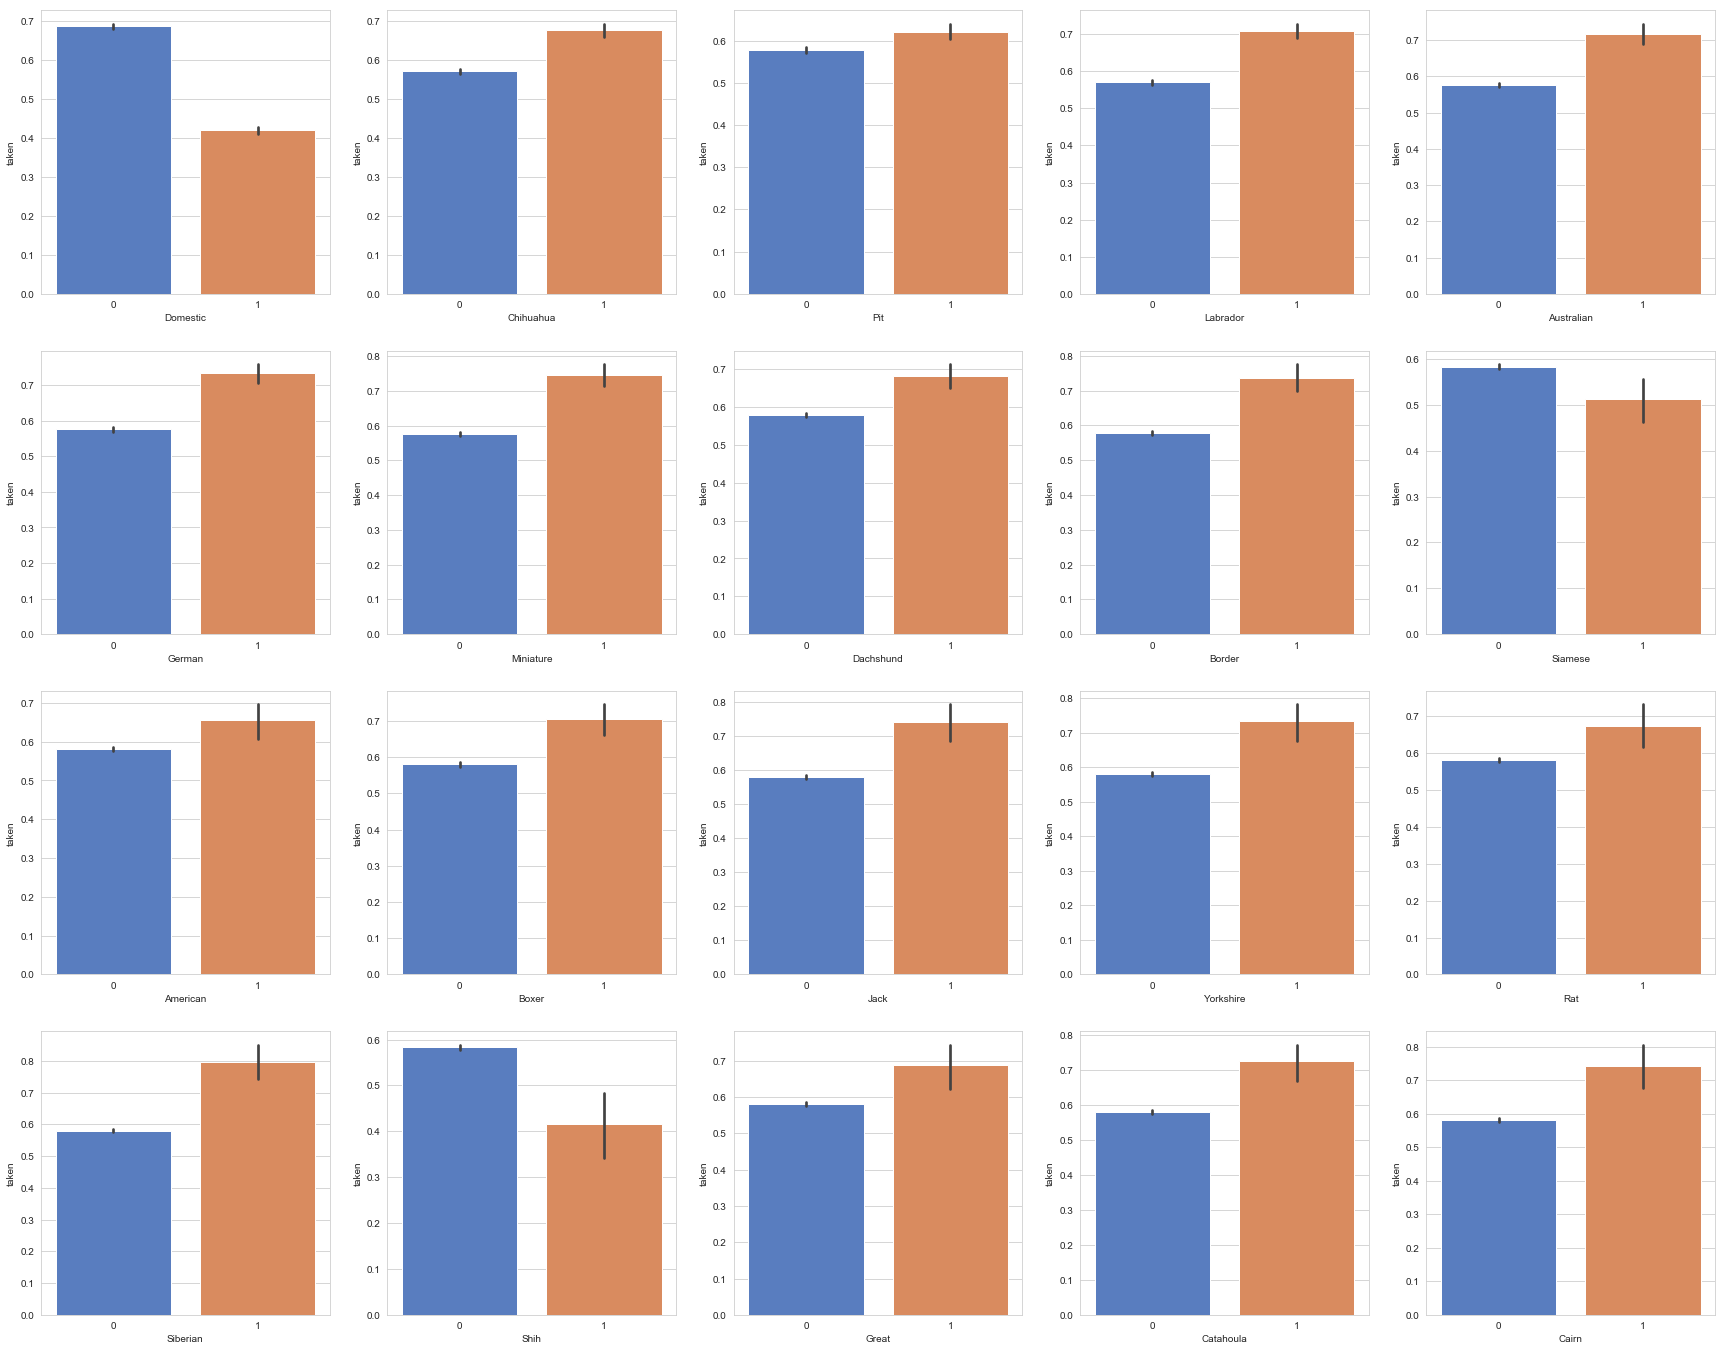

In [33]:
plt.figure(figsize=(30, 24))
for i, breed in enumerate(popular_breeds):
    plt.subplot(4, 5, i+1)
    sns.barplot(data=train, x=breed, y='taken')

We will just keep the most popular word "domestic" here, others got too small sample size.

Extract hair attribute from the breed

In [34]:
train['hair'] = train.breed.str.extract(r'(\w+)\s?[hH]air', expand=False).fillna('Unclear')

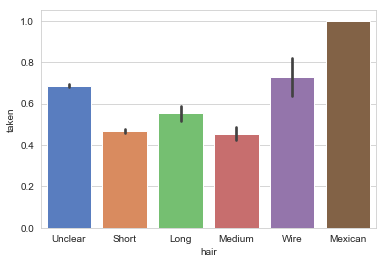

In [35]:
sns.barplot(data=train, x='hair', y='taken')

### color

First, let's find all the popular colors

In [36]:
all_colors = []
ori_colors = train.color.values
for color_str in ori_colors:
    colors = color_str.split('/')
    all_colors.extend(colors)

In [37]:
color_counts = {}
for color in all_colors:
    color_counts[color] = color_counts.get(color, 0) + 1
color_counts = pd.Series(color_counts)

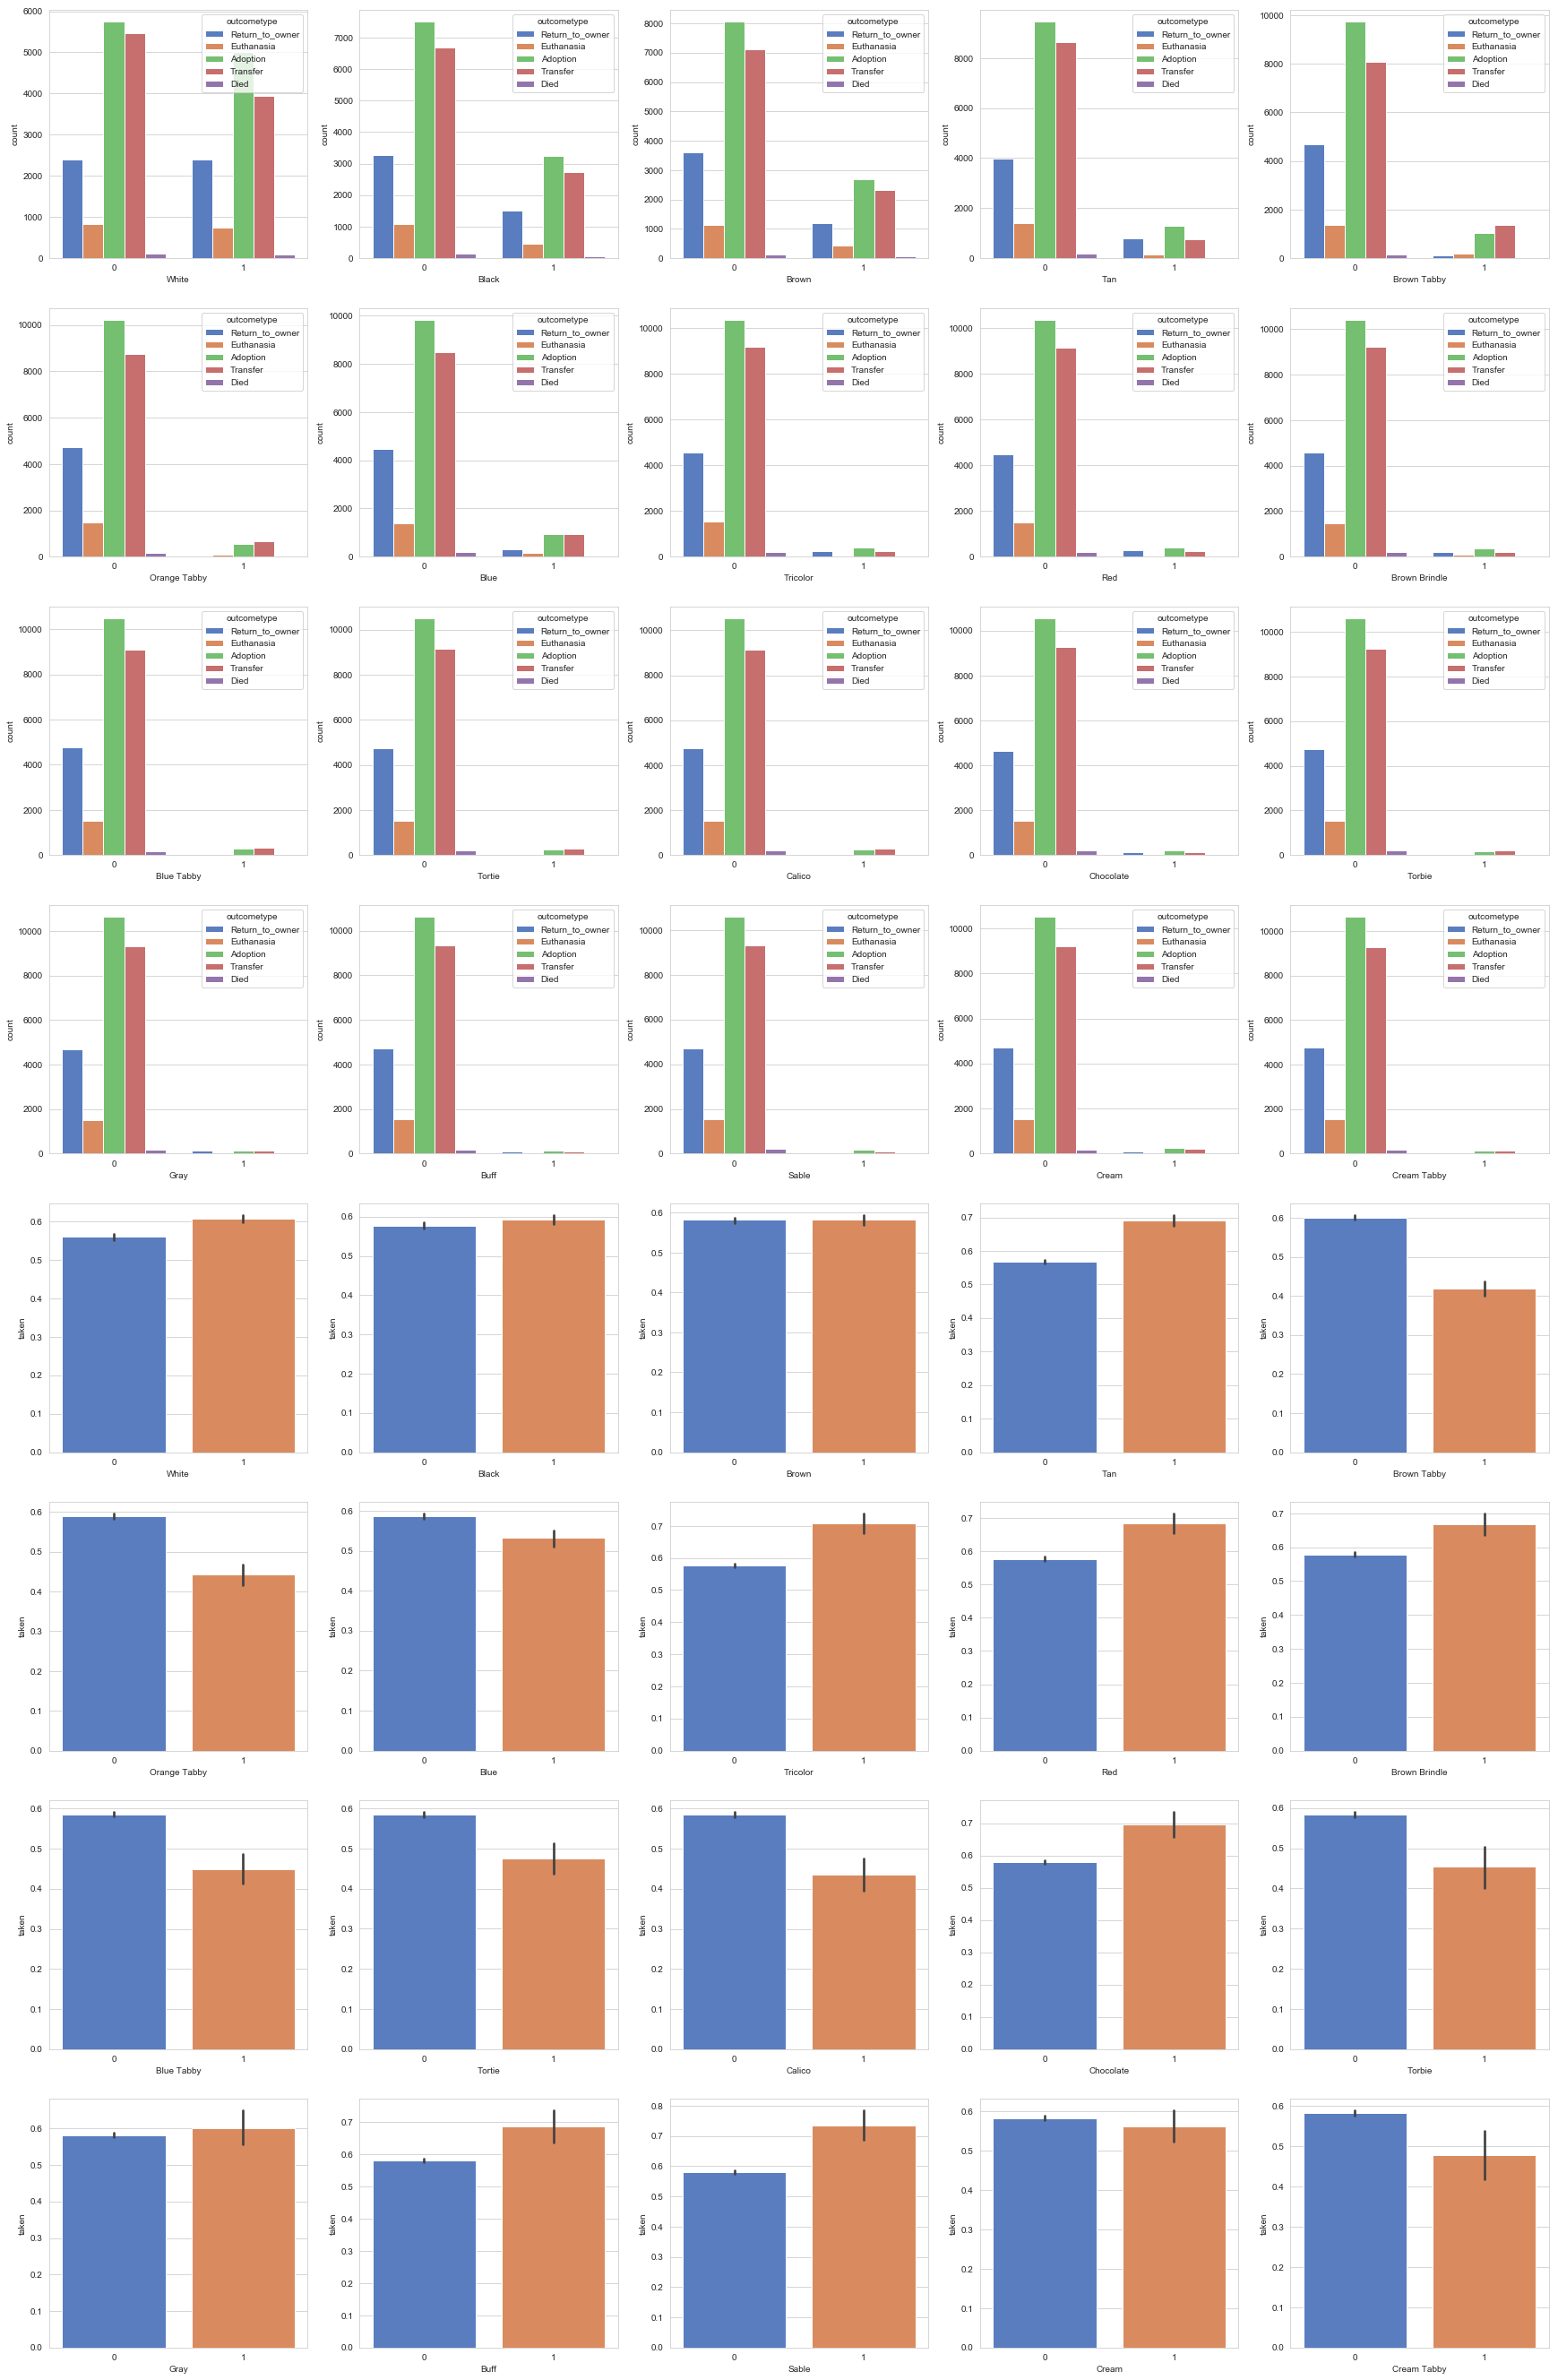

In [38]:
popular_colors = color_counts.sort_values(ascending=False)[:20].index
for color in popular_colors:
    train[color] = train.color.str.contains(color).astype(int)

plt.figure(figsize=(30, 48))
for i, color in enumerate(popular_colors):
    plt.subplot(8, 5, i+1)
    sns.countplot(data=train, x=color, hue='outcometype')
for i, color in enumerate(popular_colors):
    plt.subplot(8, 5, i+21)
    sns.barplot(data=train, x=color, y='taken')

This does not seems to be useful.

**Consider wether the pet got more than one color or not**

In [39]:
train['morethanonecolor'] = train.color.str.contains('/').astype(int)

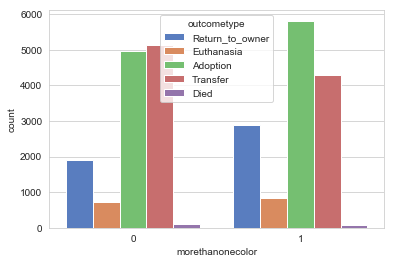

In [40]:
sns.countplot(data=train, x='morethanonecolor', hue='outcometype')